In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import speech_recognition as sr
import os 
from pydub import AudioSegment 
from pydub.silence import split_on_silence 

In [2]:
# a function that splits the audio file into chunks on each silence interval
# and applies speech recognition 
def silence_based_conversion(path): 
  
    # open the audio file stored in 
    # the local system as a wav file. 
    print("openning audio file...")
    audio = AudioSegment.from_wav(path) 
    print("audio file opened")
  
    # open a file where we will concatenate   
    # and store the recognized text 
    fh = open("recognized_text.txt", "w+") 
          
    print("splitting audio file...")
    # split track where silence is 0.5 seconds  
    # or more and get chunks 
    chunks = split_on_silence(audio, 
        # must be silent for at least 0.5 seconds 
        # or 500 ms. adjust this value based on user 
        # requirement. if the speaker stays silent for  
        # longer, increase this value. else, decrease it. 
        min_silence_len = 3000, 

        # consider it silent if quieter than -16 dBFS 
        # adjust this per requirement 
        silence_thresh = -25
    ) 
    
    print("audio file splitted")
    print("number of chunks: ", len(chunks))


    # create a directory to store the audio chunks. 
    try: 
        os.mkdir('audio_chunks')
    except(FileExistsError): 
        pass
  
    # move into the directory to 
    # store the audio files. 
    # os.chdir('audio_chunks') 
  
    i = 0
    # process each chunk 
    for chunk in chunks: 
        
        # Create 0.5 seconds silence chunk 
        chunk_silent = AudioSegment.silent(duration = 500) 
  
        # add 0.5 sec silence to beginning and  
        # end of audio chunk. This is done so that 
        # it doesn't seem abruptly sliced. 
        audio_chunk = chunk_silent + chunk + chunk_silent 
  
        # export audio chunk and save it in  
        # the current directory. 
        print("saving chunk{0}.wav".format(i)) 
        # specify the bitrate to be 192 k 
        audio_chunk.export("../data/lectures/audio_chunks/chunk{0}.wav".format(i), bitrate ='192k', format ="wav") 

        # the name of the newly created chunk 
        filename = '../data/lectures/audio_chunks/' + 'chunk'+str(i)+'.wav'

        print("Processing chunk "+str(i)) 

        # get the name of the newly created chunk 
        # in the AUDIO_FILE variable for later use. 
        file = filename 

        # create a speech recognition object 
        r = sr.Recognizer() 
        
        # recognize the chunk 
        with sr.AudioFile(file) as source: 
            # remove this if it is not working 
            # correctly. 
            # r.adjust_for_ambient_noise(source) 
            audio_listened = r.listen(source) 

        try: 
            # try converting it to text 
            rec = r.recognize_google(audio_listened) 
            # write the output to the file. 
            fh.write(rec+". ") 

        # catch any errors. 
        except sr.UnknownValueError: 
            print("Could not understand audio") 

        except sr.RequestError as e: 
            print("Could not request results. check your internet connection") 

        i += 1
        
    fh.close()
    print("all chunks processed")
  

In [3]:
def get_VAD_dictionary():
    filepath = "../data/NRC/NRC-VAD-Lexicon.txt"
    vad_dict = pd.read_csv(filepath,  names=["valence", "arousal", "dominance"], skiprows=45, sep='\t')
    vad_dict.head(12)
    print("Number of words in dictionary: ", len(vad_dict))
    return vad_dict

In [4]:
def get_vad_scores(text, vad_dict):
    scores = []
    words = text.split(' ')
    for w in words:
        try:
            value = vad_dict.loc[w]
            scores.append([w, round(value[0], 2), round(value[1], 2), round(value[2], 2)])
        except KeyError:
            pass
            scores.append([w, 0.5, 0.5, 0.5])

    print('\n'.join(str(element) for element in scores))
    vad = [score[1:] for score in scores]
    return vad

In [5]:
def moving_average(a, n=30) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [6]:
def main():
    silence_based_conversion("../data/lectures/test2.wav")
    # silence_based_conversion("../data/lectures/test.wav")
    
    with open("recognized_text.txt", "r") as file:
        text = file.read()
        
    print(text)
    vad_dict = get_VAD_dictionary()
    vad_scores = get_vad_scores(text, vad_dict)
    
    data = np.array(vad_scores)

    # GRAPHS
    
    arousal = data[:, 0]
    plt.plot(arousal)
    plt.xlabel("arousal")
    plt.show()
    
    smoothed = moving_average(arousal)
    plt.plot(smoothed)
    plt.xlabel("arousal smoothed")
    plt.show()
    
    valance = data[:, 1]
    smoothed = moving_average(valance)
    plt.plot(smoothed)
    plt.xlabel("valence smoothed")
    plt.show()
    
    valance = data[:, 2]
    smoothed = moving_average(valance)
    plt.plot(smoothed)
    plt.xlabel("dominance smoothed")
    plt.show()

openning audio file...
audio file opened
splitting audio file...
audio file splitted
number of chunks:  17
saving chunk0.wav
Processing chunk 0
Could not understand audio
saving chunk1.wav
Processing chunk 1
Could not understand audio
saving chunk2.wav
Processing chunk 2
saving chunk3.wav
Processing chunk 3
saving chunk4.wav
Processing chunk 4
saving chunk5.wav
Processing chunk 5
saving chunk6.wav
Processing chunk 6
saving chunk7.wav
Processing chunk 7
saving chunk8.wav
Processing chunk 8
saving chunk9.wav
Processing chunk 9
saving chunk10.wav
Processing chunk 10
saving chunk11.wav
Processing chunk 11
saving chunk12.wav
Processing chunk 12
saving chunk13.wav
Processing chunk 13
Could not understand audio
saving chunk14.wav
Processing chunk 14
saving chunk15.wav
Processing chunk 15
saving chunk16.wav
Processing chunk 16
Could not understand audio
all chunks processed
bathroom I challenge my students to explore the silences in their own life. within my class. on silences I have four core

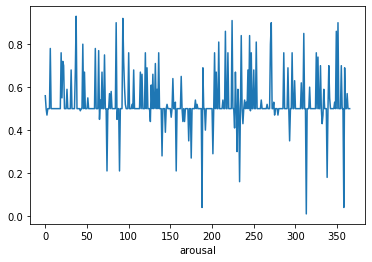

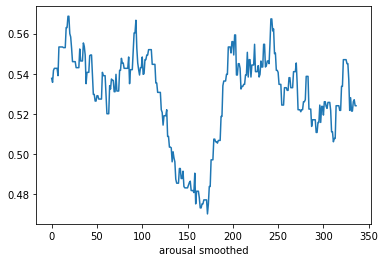

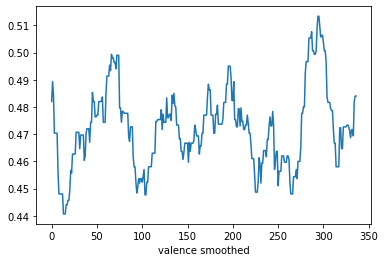

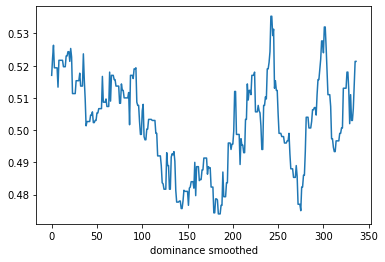

In [7]:
main()
